In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
class Neuron(object):
  def __init__(self):
    self.t = 0.          #Current time
    self.axon = []       # List of outgoing connections
  
  def slope(self):
    return 0.

  def step(self, dt):
    #self.t+dt
    raise NotImplementedError     #!!!!!!!!!
  
  def send_spike(self, n=1):
    for a in self.axon:
      a.transmit(n)

In [ ]:
class HH(Neuron):
  def __init__(self):
    super().__init__()
    self.v = 0.
    self.m = 0.
    self.h = 0.
    self.n = 0.

    #Derivates
    self.dV = 0.
    self.dm = 0.
    self.dh = 0.
    self.dn = 0.

    self.cm = 0.02 #Capacitancia de la membrana  ( mS/mm^2)

    # Set all the maximal channel conductances
    self.gL = 0.003
    self.gK = 0.36
    self.gNa = 1.2

    #Set the reverse potentials
    self.EL = -54.387
    self.Ek = -77
    self.ENa =1.2

    self.input_current = (lambda t: 0.)

  @classmethod
  def nGate(cls, V):
    '''  Evaluates the steady-state value and time constant for subgate
      n_inf, tau_n = HH.nGaate(V)

      Input:
        V is the voltage (scalar) in mV

      Output:
         n_inf is the stady-state value of n
         tau_n is the time constant for n, measured in ms'''

    # Find the values that are NOT divide-by-zero
    if (abs(V+55)> 1e-5):
      #alpha = (0.01*(V+55)) / (1-exp(-0.1*(V+55)))
      alpha = (0.01*(V+55)) / (1-np.exp(-0.1*(V+55)))
    
    else : 
      # In the case of a divide-by-zero, the value should be 0.1.
      alpha = 0.1

    beta = 0.125*np.exp(-0.0125*(V+65))

    tau_n = 1 / (alpha +beta)
    n_inf = alpha*tau_n

    return [n_inf,tau_n]


  @classmethod

  def mGate( cls, V):

    #Find the values that are NOT divide-by-zero

    if (abs(V+40)>1e-5):
      alpha = (0.1*(V+40)) / (1 -np.exp(-0.1*(V+40)))

    else :
      # In the case of a divide-by-zero, the value should be 1.
      alpha = 1.0

    beta = 4*np.exp(-0.0556*(V+65))
    tau_m = 1.0 / (alpha +beta)
    m_inf = alpha * tau_m

    return [m_inf, tau_m]

  @classmethod
  def hGate(cls, V):
    #No d-b-0 to worry about
    alpha = 0.07*np.exp(-0.05*(V+65))
    beta = 1. / (1 + np.exp(-0.1*(V+35)))

    tau_h = 1./ (alpha+ beta)
    h_inf = alpha * tau_h

    return [h_inf, tau_h]

  def axon(self):
    output = max(0, self.v-self.EL)
    return output
  
  def simulate(self, tspan, dt):
    s = 1000.
    start_ms = tspan[0]*s  # convert to ms
    end_ms = tspan[1]*s
    dt_ms = dt*s

    t_ms = start_ms
    y = np.array([self.v, self.m , self.h, self.n])

    sol = dict(t=[], y=[])
    sol['y'].append(y)
    sol['t'].append(t_ms/s)

    while t_ms<end_ms:
      self.slope(t_ms)
      self.step(dt_ms)
      t_ms += dt_ms
      sol['t'].append(t_ms/s) #record in seconds
      sol['y'].append(np.array([self.v, self.m, self.h, self.n]))
    
    sol['t'] = np.array(sol['t'])
    sol['y'] = np.array(sol['y'])

    return sol

  def slope(self,t):
    #Find out what the channels are up to at this voltage.
    # [1] for evaluating all the channel functions

    s = 1000.
    V = self.v
    ninf, taun = HH.nGate(V)
    minf, taum = HH.mGate(V)
    hinf, tauh = HH.hGate(V)

    Ie = self.input_current(t/s) #time in seconds

    #Compute the overall membrane
    # [2] for computing channel currents
    # ( part-marks: 1 for getting at least one term right)

    I = (self.gL*(V-self.EL) +
                self.gK*self.n**4*(V-self.Ek)+
                self.gNa*self.m**3*self.h*(V-self.ENa))
    
    # Here is the sistem of differential equations.
    # This is the righ-hand-side of the sistem of 4 equations.
    # [1] for evaluating the RHS of the DEs

    self.dV = (-I+Ie)/self.cm
    self.dn = (ninf - self.n)/ taun
    self.dm = (minf- self.m)/taum
    self.dh = (hinf-self.h)/tauh

    #return [self.dV, self.dm, self.dh, self.hn]+

    def step(self, dt):
      self.v += dt*self.dV
      self.m  += dt*self.dm
      self.h += dt*self.dh
      self.n += dt*self.differential

      return [self.v, self.m , self.h, self.n]



Input for Simulation

In [ ]:
# set the time span for the simulation ( in ms)
dt = 0.00001 # lenght of the time step, in units of s
t = np.arange(0.0, 0.8, dt) #Again, in units of s

#Set the initial state Vector
#           V           m           h            n  
z0 = [-53.14669365, 0.18920957, 0.21004222, 0.50796341]

#Define a function that evaluates the injected current at any time t

def InjectedCurrent(t):
  " t in ms and I in mA"

  if t> 0.0 and t< 0.2:
    return -0.2
  elif t< 0.4:
    return 0.
  elif t< 0.6:
    return 0.1
  else:
    return 0.6

J = [InjectedCurrent(tt) for tt in t]

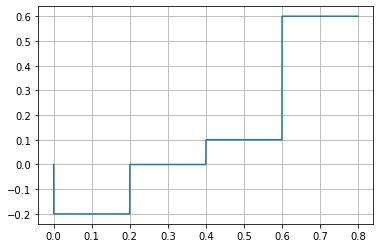

In [ ]:
plt.figure()
plt.plot(t,J); plt.grid(True);

Revisar¡¡¡¡

In [25]:
hh = HH()
tspan = [0, 0.8]
dt = 0.00001
hh.input_current = InjectedCurrent
sol = hh.simulate(tspan, dt)

NotImplementedError: ignored

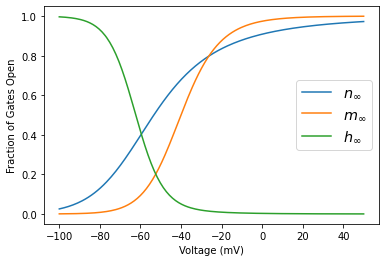

In [26]:
V  = np.linspace(-100,50,200)
plt.figure()
plt.plot( V, [hh.nGate(v)[0] for v in V])
plt.plot( V, [hh.mGate(v)[0] for v in V])
plt.plot( V, [hh.hGate(v)[0] for v in V])

plt.xlabel('Voltage (mV)')
plt.ylabel('Fraction of Gates Open')
plt.legend(('$n_\infty$', '$m_\infty$', '$h_\infty$'), fontsize = 'x-large');

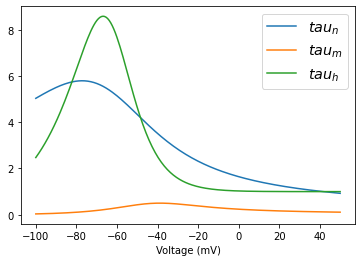

In [27]:
plt.figure()
plt.plot( V, [hh.nGate(v)[1] for v in V])
plt.plot( V, [hh.mGate(v)[1] for v in V])
plt.plot( V, [hh.hGate(v)[1] for v in V])

plt.xlabel('Voltage (mV)')
plt.legend(('$tau_n$', '$tau_m$', '$tau_h$'), fontsize = 'x-large');

In [28]:
plt.plot(sol['t'], sol['y'][:,0])
plt.grid('on');

NameError: ignored

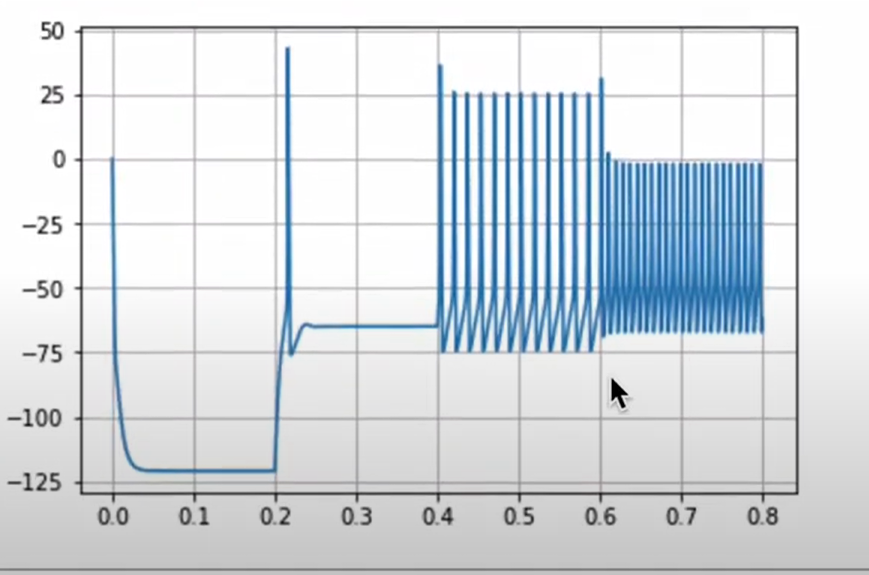